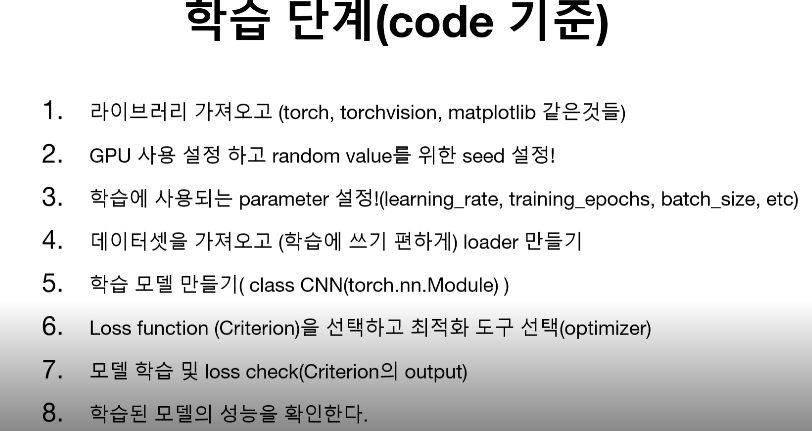

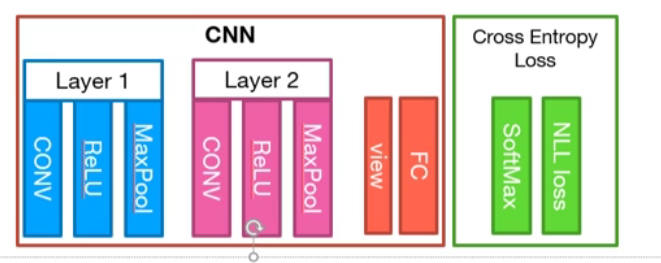

In [1]:
import torch
import torch.nn as nn

inputs = torch.Tensor(1,1,28,28)
inputs.shape


torch.Size([1, 1, 28, 28])

In [2]:
conv1 = nn.Conv2d(1,32,3,padding=1)
pool = nn.MaxPool2d(2)
pool


MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [3]:
conv2 = nn.Conv2d(32,64,3,padding=1)
conv2

Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [4]:
out = conv1(inputs)
out.shape

torch.Size([1, 32, 28, 28])

In [5]:
out = pool(out)
out.shape

C:\ProgramData\Miniconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 32, 14, 14])

In [6]:
out = conv2(out)
out.shape

torch.Size([1, 64, 14, 14])

In [7]:
out = pool(out)
out.shape

torch.Size([1, 64, 7, 7])

In [8]:
out = out.view(out.size(0),-1)
out.shape

torch.Size([1, 3136])

In [9]:
fc= nn.Linear(3136,10)
out = fc(out)
out.shape

torch.Size([1, 10])

배치 사이즈에 맞는 10개의 layer가 만들어진다. (conv 사용)

In [48]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.init

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [56]:
torch.cuda.is_available()

False

In [18]:
#parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [27]:
mnist_train = dsets.MNIST(root='MNIST_data/',train=True,transform=transforms.ToTensor(),download=True)

C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [29]:
mnist_test = dsets.MNIST(root='MNIST_data/',train=False,transform=transforms.ToTensor(),download=True)

In [31]:
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size = batch_size,shuffle= True,drop_last=True)

In [73]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                   nn.ReLU(),nn.MaxPool2d(2))
        
        self.fc = nn.Linear(7*7*64, 10,bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [74]:
model = CNN().to(device)
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [75]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
#training
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X,Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterion(hypothesis,Y)
        cost.backward()
        optimizer.step()
        
        avg_cost +=cost / batch_size
        
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
print('Learning FINISHED')
        
        

[Epoch:1] cost = 0.035920772701501846
[Epoch:2] cost = 0.0330369733273983
[Epoch:3] cost = 0.03671938553452492
[Epoch:4] cost = 0.029330557212233543
[Epoch:5] cost = 0.01889384537935257
[Epoch:6] cost = 0.02104509249329567
[Epoch:7] cost = 0.023238087072968483
[Epoch:8] cost = 0.017861107364296913
[Epoch:9] cost = 0.011555452831089497
[Epoch:10] cost = 0.034083157777786255


In [79]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction,1) == Y_test # 이부분 이해필요
    accuracy = correct_prediction.float().mean()
    print('Accuracy', accuracy.item())

C:\ProgramData\Miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy 0.9847999811172485


In [ ]:
device cuda 설정

트레인 데이터 테스트데이터 나누기
데이터 불러오기


기본적 모델 class 만들기

모델에 트레인 값 넣기

표준화 함수 선택
최적화 함수 선택

에폭 돌리기
 이미지데이터, 라벨 데이터 구분후
    
 학습시켜주기 제로 그레이드, 코스트 백워드(백프로파게이션을 이용해 코스트함수 업데이트)
 옵티마이저 스텝(학습후 다음 학습이 이어지게 만듬)
 
 평균 코스트값을 구한다 코스트값 / 토탈 배치
    
윗 노그레이드 경사값을 활용하지않음 어차피 아닌 부분 제외하여 역전파시 계산 속도를 높임
학습한 '모델'을 활용하여 성능을 측정


 